In [14]:

import numpy as np
import sys
import time
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Input,
    InputLayer,
    Flatten,
    Activation,
    Dense)
from keras.layers.convolutional import (
    Convolution2D,
    MaxPooling2D)
from keras.activations import *
from keras.models import Model, Sequential
from keras.applications import vgg16, imagenet_utils
import keras.backend as K
import numpy
import math
import matplotlib.pyplot as plt
import PIL

In [73]:

class DConvolution2D(object):

    def __init__(self, layer):
        self.layer = layer

        weights = layer.get_weights()
        W = weights[0]

        b = weights[1]

        filters = W.shape[3]
        up_row = W.shape[0]
        up_col = W.shape[1]
        input_img = keras.layers.Input(shape=layer.input_shape[1:])

        output = keras.layers.Conv2D(filters, (up_row, up_col), kernel_initializer=tf.constant_initializer(W),
                                     bias_initializer=tf.constant_initializer(b), padding='same')(input_img)
        self.up_func = K.function([input_img], [output])

        # Deconv filter (exchange no of filters and depth of each filter)
        W = np.transpose(W, (0, 1, 3, 2))
        # Reverse columns and rows
        W = W[::-1, ::-1, :, :]
        down_filters = W.shape[3]
        down_row = W.shape[0]
        down_col = W.shape[1]
        b = np.zeros(down_filters)
        input_d = Input(shape=layer.output_shape[1:])

        output = keras.layers.Conv2D(down_filters, (down_row, down_col), kernel_initializer=tf.constant_initializer(W),
                                     bias_initializer=tf.constant_initializer(b), padding='same')(input_d)
        self.down_func = K.function([input_d], [output])

    def up(self, data):
        # Forward pass
        self.up_data = self.up_func([data])
        # self.up_data = np.squeeze(self.up_data, axis=0)
        # self.up_data = numpy.expand_dims(self.up_data, axis=0)
        # print(self.up_data.shape)
        return self.up_data

    def down(self, data):
        # Backward pass
        self.down_data = self.down_func([data])
        # self.down_data = np.squeeze(self.down_data, axis=0)
        # self.down_data = numpy.expand_dims(self.down_data, axis=0)
        # print(self.down_data.shape)
        return self.down_data


class DActivation(object):
    def __init__(self, layer, linear=False):
        self.layer = layer
        self.linear = linear
        self.activation = layer.activation
        input = K.placeholder(shape=layer.output_shape)

        output = self.activation(input)
        # According to the original paper,
        # In forward pass and backward pass, do the same activation(relu)
        # Up method
        self.up_func = K.function([input], [output])
        # Down method
        self.down_func = K.function([input], [output])

    def up(self, data):
        self.up_data = self.up_func([data])
        # self.up_data = np.squeeze(self.up_data, axis=0)
        # self.up_data = numpy.expand_dims(self.up_data, axis=0)
        # print(self.up_data.shape)
        return self.up_data

    def down(self, data):
        self.down_data = self.down_func([data])
        # self.down_data = np.squeeze(self.down_data, axis=0)
        # self.down_data = numpy.expand_dims(self.down_data, axis=0)
        # print(self.down_data.shape)
        return self.down_data


class DInput(object):

    def __init__(self, layer):
        self.layer = layer

    # input and output of Input layer are the same
    def up(self, data):
        self.up_data = data
        return self.up_data

    def down(self, data):
        # data=np.squeeze(data,axis=0)
        data = numpy.expand_dims(data, axis=0)
        self.down_data = data
        return self.down_data




class DPooling(object):

    def __init__(self, layer):

        self.layer = layer
        self.poolsize = layer.pool_size

    def up(self, data):

        [self.up_data, self.switch] = \
            self.__max_pooling_with_switch(data, self.poolsize)
        return self.up_data

    def down(self, data):

        self.down_data = self.__max_unpooling_with_switch(data, self.switch)
        return self.down_data

    def __max_pooling_with_switch(self, input, poolsize):
        
        input = np.array(input)
        switch = np.zeros(input.shape)
        out_shape = list(input.shape)
        row_poolsize = int(poolsize[0])
        col_poolsize = int(poolsize[1])
        print(row_poolsize)
        print(col_poolsize)
        out_shape[1] = math.floor(out_shape[1] / poolsize[0])
        out_shape[2] = math.floor(out_shape[2] / poolsize[1])
        print(out_shape)
        pooled = np.zeros(out_shape)

        for sample in range(input.shape[0]):
            for dim in range(input.shape[3]):
                for row in range(out_shape[1]):
                    for col in range(out_shape[2]):
                        patch = input[sample,
                                row * row_poolsize: (row + 1) * row_poolsize,
                                col * col_poolsize: (col + 1) * col_poolsize, dim]
                        max_value = patch.max()
                        pooled[sample, row, col, dim] = max_value
                        max_col_index = patch.argmax(axis=1)
                        max_cols = patch.max(axis=1)
                        max_row = max_cols.argmax()
                        max_col = max_col_index[max_row]
                        switch[sample,
                               row * row_poolsize + max_row,
                               col * col_poolsize + max_col,
                               dim] = 1
        return [pooled, switch]

    # Compute unpooled output using pooled data and switch
    def __max_unpooling_with_switch(self, input, switch):

        print('switch ' + str(switch.shape))
        print('input  ' + str(input.shape))
        tile = np.ones((math.floor(switch.shape[1] / input.shape[1]),
                        math.floor(switch.shape[2] / input.shape[2])))
        print('tile ' + str(tile.shape))
        tile = numpy.expand_dims(tile, axis=3)
        input = numpy.squeeze(input, axis=0)
        out = np.kron(input, tile)
        print('out ' + str(out.shape))
        unpooled = out * switch
        unpooled = numpy.expand_dims(unpooled, axis=0)
        return unpooled


class DDense(object):

    def __init__(self, layer):
        self.layer = layer
        weights = layer.get_weights()
        W = weights[0]
        b = weights[1]

        # Up method
        input = Input(shape=layer.input_shape[1:])
        output = keras.layers.Dense(layer.output_shape[1],
                                    kernel_initializer=tf.constant_initializer(W),
                                    bias_initializer=tf.constant_initializer(b))(input)
        self.up_func = K.function([input], [output])

        # Transpose W  for down method
        W = W.transpose()
        self.input_shape = layer.input_shape
        self.output_shape = layer.output_shape
        b = np.zeros(self.input_shape[1])
        flipped_weights = [W, b]
        input = Input(shape=self.output_shape[1:])
        output = keras.layers.Dense(self.input_shape[1:],
                                    kernel_initializer=tf.constant_initializer(W),
                                    bias_initializer=tf.constant_initializer(b))(input)
        self.down_func = K.function([input], [output])

    def up(self, data):
        self.up_data = self.up_func([data])
        # self.up_data = np.squeeze(self.up_data, axis=0)
        # self.up_data = numpy.expand_dims(self.up_data, axis=0)
        # print(self.up_data.shape)
        return self.up_data

    def down(self, data):
        self.down_data = self.down_func([data])
        # self.down_data = np.squeeze(self.down_data, axis=0)
        # self.down_data = numpy.expand_dims(self.down_data, axis=0)
        # print(self.down_data.shape)
        return self.down_data


class DFlatten(object):

    def __init__(self, layer):
        self.layer = layer
        self.shape = layer.input_shape[1:]
        self.up_func = K.function([layer.input], [layer.output])

    # Flatten 2D input into 1D output
    def up(self, data):
        self.up_data = self.up_func([data])
        # self.up_data = np.squeeze(self.up_data, axis=0)
        # self.up_data = numpy.expand_dims(self.up_data, axis=0)
        # print(self.up_data.shape)
        return self.up_data

    # Reshape 1D input into 2D output
    def down(self, data):
        new_shape = [data.shape[0]] + list(self.shape)
        assert np.prod(self.shape) == np.prod(data.shape[1:])
        self.down_data = np.reshape(data, new_shape)
        return self.down_data


def bulid_DCNN(model, layer_name=None, id_layer=None):
    # get id_layer: the last layer to enable switch
    if id_layer is None:
        if layer_name is None:
            raise ValueError("must have id_layer or layer_name")
        else:
            id_layer = 0
            for i in range(len(model.layers)):
                id_layer += 1
                if layer_name == model.layers[i].name:
                    break
            print(id_layer)

    # build the deconv_layers
    deconv_layers = []
    # Stack layers
    for i in range(id_layer):
        print(i)
        if isinstance(model.layers[i], Convolution2D):
            deconv_layers.append(DConvolution2D(model.layers[i]))
            deconv_layers.append(DActivation(model.layers[i]))
        elif isinstance(model.layers[i], MaxPooling2D):
            deconv_layers.append(DPooling(model.layers[i]))
        elif isinstance(model.layers[i], Dense):
            deconv_layers.append(DDense(model.layers[i]))
            deconv_layers.append(DActivation(model.layers[i]))
        elif isinstance(model.layers[i], Activation):
            deconv_layers.append(DActivation(model.layers[i]))
        elif isinstance(model.layers[i], Flatten):
            deconv_layers.append(DFlatten(model.layers[i]))
        elif isinstance(model.layers[i], InputLayer):
            deconv_layers.append(DInput(model.layers[i]))
        else:
            print('Cannot handle this type of layer')
            print(model.layers[i].get_config())
            sys.exit()

    return deconv_layers


def visualize(model, data, layer_name, feature_to_visualize, visualize_mode="all"):
    deconv_layers = bulid_DCNN(model, layer_name=layer_name)

    # Forward pass: get feature map
    deconv_layers[0].up(data)
    for i in range(1, len(deconv_layers)):
        deconv_layers[i].up(deconv_layers[i - 1].up_data)
    output = deconv_layers[-1].up_data

    # up to conv layers, ndim is 4. up to dense layer, ndim is 2
    print(output.shape)
    assert output.ndim == 2 or output.ndim == 4
    if output.ndim == 2:
        feature_map = output[:, feature_to_visualize]
    else:
        feature_map = output[:, :, :, feature_to_visualize]

    # visualize the reconstruct pattern based on different visualize_mode
    if 'max' == visualize_mode:
        max_activation = feature_map.max()
        temp = feature_map == max_activation
        feature_map = feature_map * temp
    elif 'all' != visualize_mode:
        print('Illegal visualize mode')
        sys.exit()

    output = np.zeros_like(output)
    if 2 == output.ndim:
        output[:, feature_to_visualize] = feature_map
    else:
        output[:, :, :, feature_to_visualize] = feature_map

    # Backward pass
    deconv_layers[-1].down(output)
    for i in range(len(deconv_layers) - 2, -1, -1):
        deconv_layers[i].down(deconv_layers[i + 1].down_data)
    deconv = deconv_layers[0].down_data
    deconv = deconv.squeeze()

    visualize_reconstruct_pattern(deconv)


def visualize_reconstruct_pattern(deconv):
    print(deconv.shape)
    deconv = deconv - deconv.min()
    deconv *= 1.0 / (deconv.max() + 1e-8)
    # deconv = deconv[:, :, ::-1]
    uint8_deconv = (deconv * 255).astype(np.uint8)
    img = Image.fromarray(uint8_deconv, 'RGB')
    return img


def load_img(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224), resample=PIL.Image.NEAREST)
    img_array = np.array(img)
    img_array = img_array[np.newaxis, :]
    img_array = img_array.astype(np.float)
    img_array = imagenet_utils.preprocess_input(img_array)
    print(img_array.shape)
    return img_array


In [2]:
model = vgg16.VGG16(weights = 'imagenet', include_top = True)

553467904/553467096 [==============================] - 84s 0us/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3)


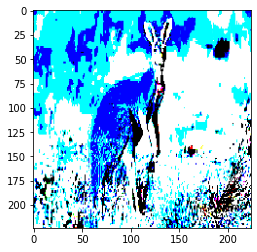

In [7]:
# Load data and preprocess
image_path = "./material/kangaroo.jpg"
img_array = load_img(image_path)

# Original image
plt.imshow(img_array[0])
plt.show()

In [60]:
for l in model.layers:
    print(l)

In [74]:
deconv_layers = bulid_DCNN(model, layer_name='block3_conv3')


10
0
1
2
3
4
5
6
7
8
9


In [75]:
for layer in deconv_layers: 
    print(layer)

In [77]:
print(img_array.shape)
# Forward pass: get feature map
deconv_layers[0].up(img_array)
print(deconv_layers[0].up_data.shape)
for i in range(1, len(deconv_layers)):
    print("d", i)
    deconv_layers[i].up(deconv_layers[i - 1].up_data)
    # print(deconv_layers[i].up_data)
output = deconv_layers[-1].up_data

(1, 224, 224, 3)
(1, 224, 224, 3)
d 1
d 2
d 3
d 4
d 5
2
2
[1, 0, 112, 224, 64]
d 6


ValueError: Input 0 is incompatible with layer model_407: expected shape=(None, 112, 112, 64), found shape=(1, 0, 112, 224, 64)